# Прогнозирование биологического ответа

## Домашняя работа по подбору гиперпараметров модели. 

### Постановка задачи.

1. Данные хранятся в файле data/_train_sem09.csv
Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

2. Необходимо обучить логистическую регрессию и случайный лес. 

3. В качестве метрики использовать f1-score

4. Для подбора гиперпараметров использовать четыре модели (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna), максимальное количество итераций не должно превышать 50.

In [30]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
import warnings

### 1. Обучение моделей без подбора гиперпараметров. 

In [3]:
# Подгрузка данных

data = pd.read_csv('data/_train_sem09.csv')
data.head(3)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0


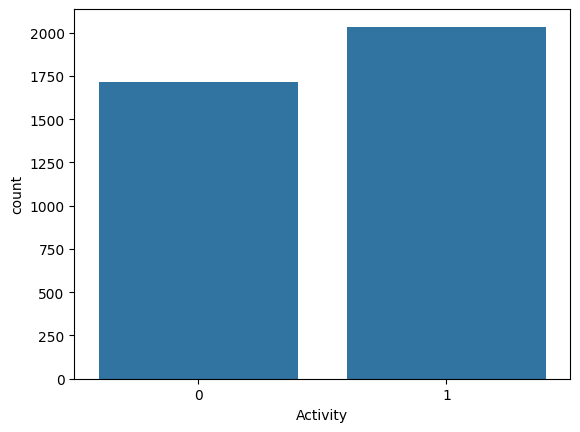

In [7]:
# Посмотрим на распределение выходных данных

sns.countplot(data=data, x='Activity');

Количество данных с ответом "1" немного превышает количество данных с ответом "0". На всякий случай при разбиении данных на тест и трейн используем стратификацию

In [8]:
# Разбиение данных
X = data.drop(['Activity'], axis = 1)
y = data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [12]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.89
f1_score на тестовом наборе: 0.78


In [11]:
#Создаем объект класса  случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.80


Видим, что случайный лес справился с задачей немного лучше, чем логистическая регрессия, но при этом переобучился.

### 2. Подбор гиперпараметров с помощью **GridSearchCV**

In [27]:
# Пройдемся по логистической регрессии
param_grid_lg = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid_lg, 
    cv=5, 
    n_jobs = -1
) 

%time grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)
    
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1

CPU times: user 3.02 s, sys: 1.09 s, total: 4.11 s
Wall time: 10min 54s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


Потратили больше 10 минут, а метрику не улучшили. 

In [28]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(C=0.3, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


In [31]:
# Посмотрим теперь на случайный лес
param_grid_rf = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9] 
} 

grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs = -1
) 

%time grid_search_rf.fit(X_train, y_train)
y_test_pred_rf = grid_search_rf.predict(X_test)
    
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

CPU times: user 13.4 s, sys: 432 ms, total: 13.8 s
Wall time: 4min 3s
f1_score на тестовом наборе: 0.77
Наилучшие значения гиперпараметров: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 150}


Для случайного леса мы получили даже ухудшение метрики. Возможно, стоит повторить поиск с другими параметрами

In [32]:
# Изменим немного параметры
param_grid_rf = { 
    'n_estimators': [150, 175, 200, 225], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 4, 5], 
    'max_leaf_nodes': [9, 10, 11, 12] 
} 

grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs = -1
) 

%time grid_search_rf.fit(X_train, y_train)
y_test_pred_rf = grid_search_rf.predict(X_test)
    
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

CPU times: user 19.8 s, sys: 1.12 s, total: 20.9 s
Wall time: 13min 58s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 4, 'max_features': None, 'max_leaf_nodes': 12, 'n_estimators': 150}


Метрика немного улучшилось, но пришлось потратить на это еще 13 минут. 

### 3. Подбор гиперпараметров с помощью **RandomizedSearchCV**

In [33]:
# Сначала для логистической регрессии
param_distributions = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

random_search_lg = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  

%time random_search_lg.fit(X_train, y_train) 

y_test_pred = random_search_lg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lg.best_params_))

/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alef/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1

CPU times: user 36.2 s, sys: 416 ms, total: 36.6 s
Wall time: 3min 49s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.34}


За 3 минуты получили такую же метрику, как и при помощи GridSearchCV за 10 минут. Но улучшить метрику не удалось.

In [36]:
# Попробуем подобрать гиперпараметры для случайного леса 

param_distributions_rf = { 
    'n_estimators': list(np.linspace(25, 500, 50, dtype = int)), 
    'max_depth': list(np.linspace(1, 30, 50, dtype=int)), 
    'max_leaf_nodes': list(np.linspace(5, 100, 50, dtype=int)),

}

random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions_rf, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_rf.fit(X_train, y_train) 

y_test_pred_rf = random_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_)) 


CPU times: user 4.42 s, sys: 359 ms, total: 4.78 s
Wall time: 1min 11s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 451, 'max_leaf_nodes': 98, 'max_depth': 15}


Чуть больше чем за одну минуту удалось улучшить метрику для случайного леса.

### 4. Подбор гиперпараметров при помощи **Hyperopt**

In [37]:
space_lg={'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
       'C' : hp.uniform('C', 0.05, 3),
       'max_iter' : hp.choice('max_iter', range(5,1000))
      }

In [38]:
random_state = 42
def hyperopt_lg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'solver': params['solver'], 
              'C': float(params['C']), 
             'max_iter': int(params['max_iter'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [45]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lg, # наша функция 
          space=space_lg, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:59<00:00,  5.99s/trial, best loss: -0.9133089133089133]
Наилучшие значения гиперпараметров {'C': 2.963824775282104, 'max_iter': 870, 'solver': 0}
CPU times: user 4min 22s, sys: 1min 12s, total: 5min 34s
Wall time: 1min 59s


In [46]:
#рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state,
    max_iter=int(best['max_iter']),
    C=best['C']
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.77


Метрика немного хуже, чем у предыдущих способов подбора гиперпараметров. Попробуем продолжить подбор

In [47]:
best=fmin(hyperopt_lg, # наша функция 
          space=space_lg, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 30/30 [00:56<00:00,  5.64s/trial, best loss: -0.9133089133089133]
Наилучшие значения гиперпараметров {'C': 2.963824775282104, 'max_iter': 870, 'solver': 0}


Ничего не изменилось. Похоже, алгоритм нашел наилучшие по его мнению гиперпараметры.

In [63]:
# Попробуем теперь подобрать параметры для случайного леса

space_rf={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 2),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 9, 1)
      }

In [64]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [65]:
%%time
# начинаем подбор гиперпараметров

trials_rf = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция 
          space=space_rf, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials_rf, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_rf))

100%|██████████| 20/20 [00:32<00:00,  1.63s/trial, best loss: -0.9743433109346366]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 110.0}
CPU times: user 32.3 s, sys: 279 ms, total: 32.6 s
Wall time: 32.6 s


In [66]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_test_pred_rf = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))

f1_score на тестовом наборе: 0.79


И опять, при этом способе оптимизации гиперпараметров значение метрики на тестовой выборке хуже, чем при RandomizedSearchCV

### 5. Подбор гиперпараметров при помощи **Optuna**

In [56]:

#Сначала для логистической регрессии
def optuna_lg(trial):
  # задаем пространства поиска гиперпараметров
  c = trial.suggest_float('C', 0.05, 3)
  solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
  max_iter = trial.suggest_int('max_iter', 5, 1000)

  # создаем модель
  model = linear_model.LogisticRegression(C=c,
                                          solver=solver,
                                          max_iter=max_iter,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [57]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lg, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2024-03-21 13:51:54,631] A new study created in memory with name: LogisticRegression
[I 2024-03-21 13:51:56,611] Trial 0 finished with value: 0.9048200122025625 and parameters: {'C': 2.172034139887117, 'solver': 'lbfgs', 'max_iter': 485}. Best is trial 0 with value: 0.9048200122025625.
[I 2024-03-21 13:51:58,690] Trial 1 finished with value: 0.8978102189781022 and parameters: {'C': 1.4135033656106584, 'solver': 'newton-cg', 'max_iter': 699}. Best is trial 0 with value: 0.9048200122025625.
[I 2024-03-21 13:51:59,193] Trial 2 finished with value: 0.9102564102564104 and parameters: {'C': 2.7158895312905273, 'solver': 'liblinear', 'max_iter': 642}. Best is trial 2 with value: 0.9102564102564104.
[I 2024-03-21 13:52:03,826] Trial 3 finished with value: 0.8966565349544073 and parameters: {'C': 1.9813759757536762, 'solver': 'sag', 'max_iter': 207}. Best is trial 2 with value: 0.9102564102564104.
[I 2024-03-21 13:52:19,862] Trial 4 finished with value: 0.9091463414634147 and parameters: {'C

Наилучшие значения гиперпараметров {'C': 2.9967253263596993, 'solver': 'liblinear', 'max_iter': 55}
f1_score на обучающем наборе: 0.91
CPU times: user 2min 12s, sys: 34.8 s, total: 2min 47s
Wall time: 1min 8s


In [58]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.77


Получился такой же результат, как для Hyperopt, но за меньшее время. 

In [59]:
#Проделаем то же самое для случайного леса
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf',3, 9, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [60]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

[I 2024-03-21 13:56:23,959] A new study created in memory with name: RandomForestClassifier
[I 2024-03-21 13:56:25,773] Trial 0 finished with value: 0.9302042060347455 and parameters: {'n_estimators': 200, 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9302042060347455.
[I 2024-03-21 13:56:27,707] Trial 1 finished with value: 0.9112534309240622 and parameters: {'n_estimators': 230, 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9302042060347455.
[I 2024-03-21 13:56:29,715] Trial 2 finished with value: 0.9040097205346294 and parameters: {'n_estimators': 240, 'max_depth': 31, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9302042060347455.
[I 2024-03-21 13:56:30,804] Trial 3 finished with value: 0.928311057108141 and parameters: {'n_estimators': 120, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9302042060347455.
[I 2024-03-21 13:56:31,661] Trial 4 finished with value: 0.9404943545926152 and parameters: {'n_e

CPU times: user 33 s, sys: 257 ms, total: 33.2 s
Wall time: 33.2 s


In [61]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.97


In [62]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_test_pred_rf = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))

f1_score на тестовом наборе: 0.80


**Удалось получить максимальное значение метрики за сравнительно небольшое время**

###  **Вывод:** 

1. Для случайного леса лучше всего по скорости и значению метрики отработал алгоритм **Optuna**. 

2. Для логистической регрессии лучше всего по скорости и значению метрики отработал алгоритм **RandomizedSearchCV**. 